In [42]:
from tensorflow.keras.models import load_model
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300# Calculate the confusion matrix
from sklearn.metrics import roc_auc_score,roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
import contractions
import re
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report



In [44]:
#training constants


train_path = 'Train_Dataset.csv'
test_path = 'Test_Dataset.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

data=pd.concat([train,test],axis=0)
train, test = train_test_split(data, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)
MAX_SEQ_LEN = 36 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 16

def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
    text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):

        mapped_string.append(contractions.fix(t))  
    return ' '.join(mapped_string)

train_text_vec = [clean_text(text, contractions.fix) for text in train['tweet'].values]
test_text_vec = [clean_text(text, contractions.fix) for text in test['tweet'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)
encoder = LabelEncoder()
y_train = encoder.fit_transform(train['sarcastic'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['sarcastic'].values)
# y_test = to_categorical(y_test) 
print("data created")

(7500, 2)
(834, 2)
data created


In [78]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load your trained model
model = load_model("model_1c.h5")  ## change the model name here 

import tensorflow as tf
with tf.device('/cpu:0'):
    predictions = model.predict(test_text_vec, verbose=1)
#     print('Validation Loss:', log_loss(y_test, predictions))
y_pred = np.argmax(predictions, axis=1)

# Generate the classification report
classification_report(y_test, y_pred)


27/27 [==============================] - 2s 50ms/step


'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.95       655\n           1       0.82      0.84      0.83       179\n\n    accuracy                           0.92       834\n   macro avg       0.89      0.89      0.89       834\nweighted avg       0.93      0.92      0.92       834\n'

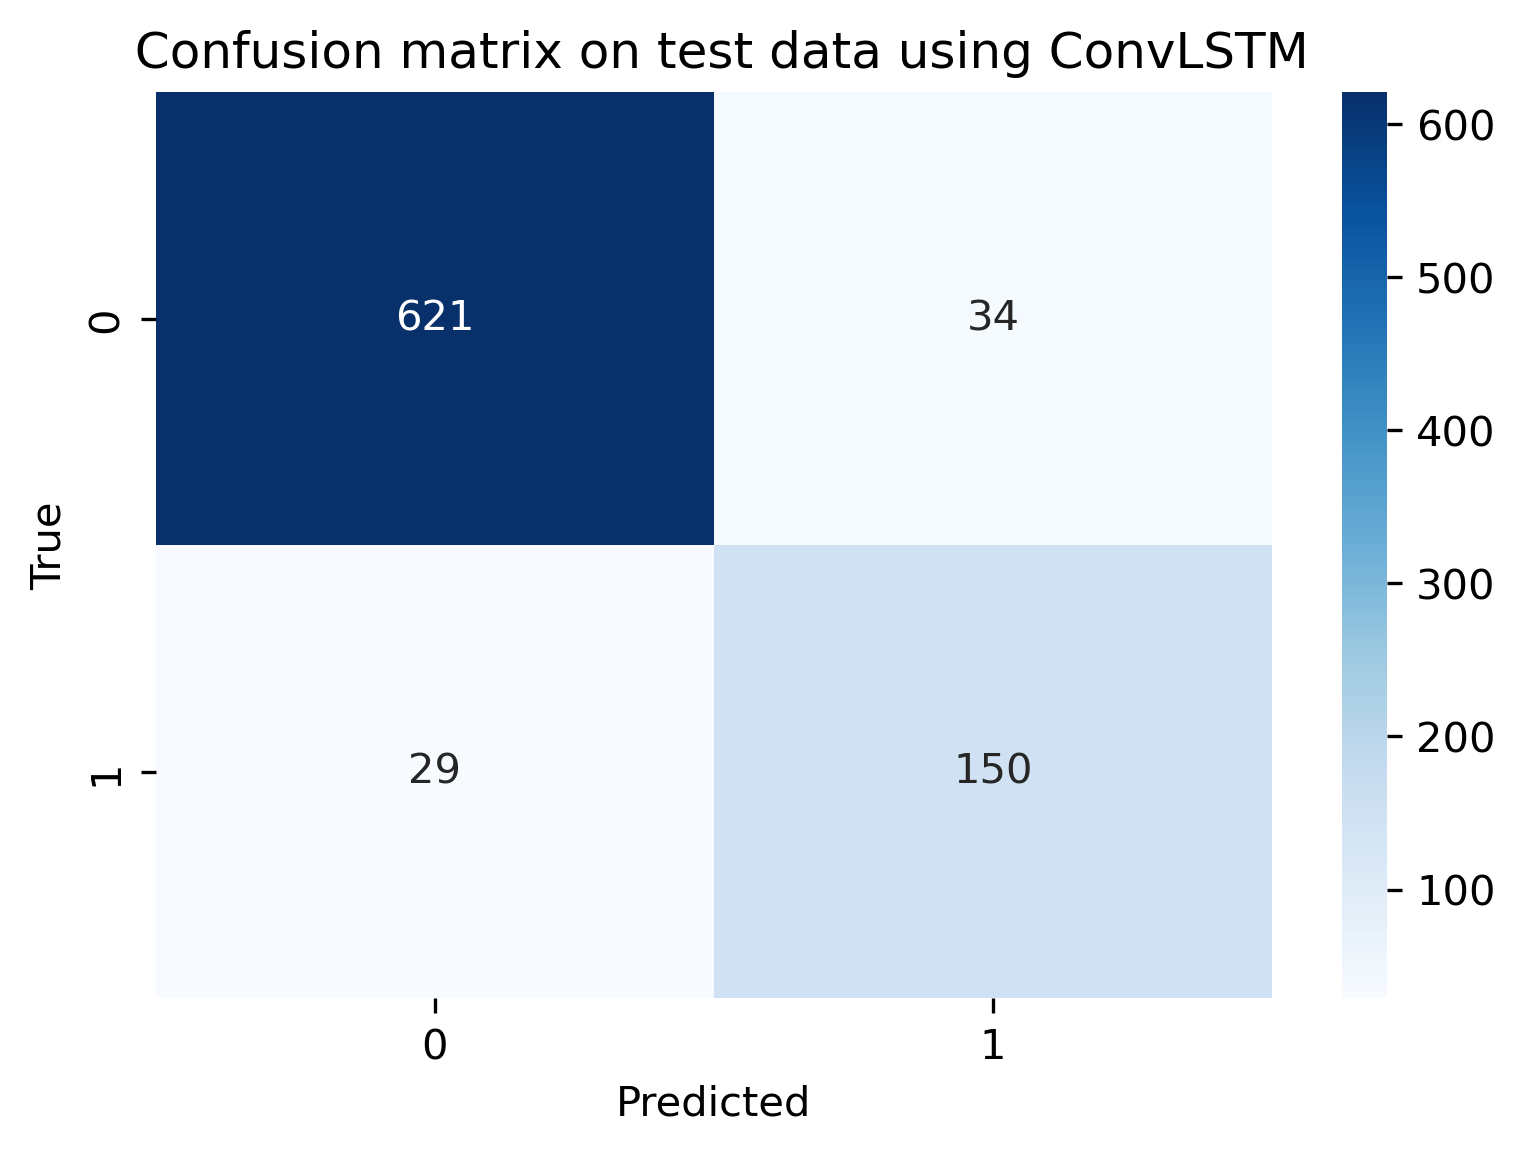

In [69]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap="Blues",fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(" Confusion matrix on test data using ConvLSTM")
plt.show()

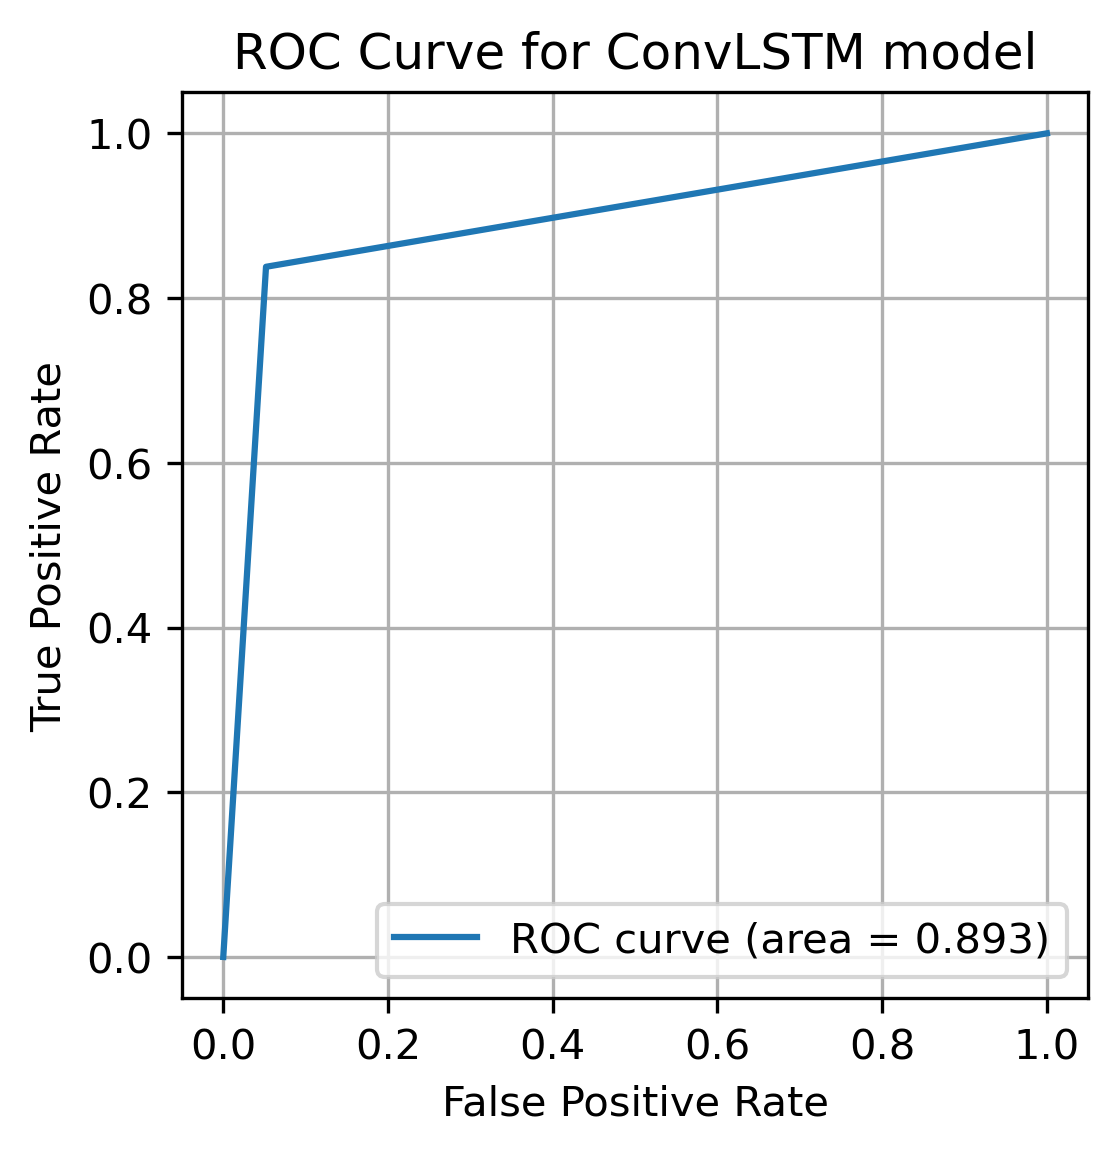

In [77]:



# Compute the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the AUC
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ConvLSTM model')
plt.legend(loc='best')
plt.grid()
plt.axis('square')
plt.show()


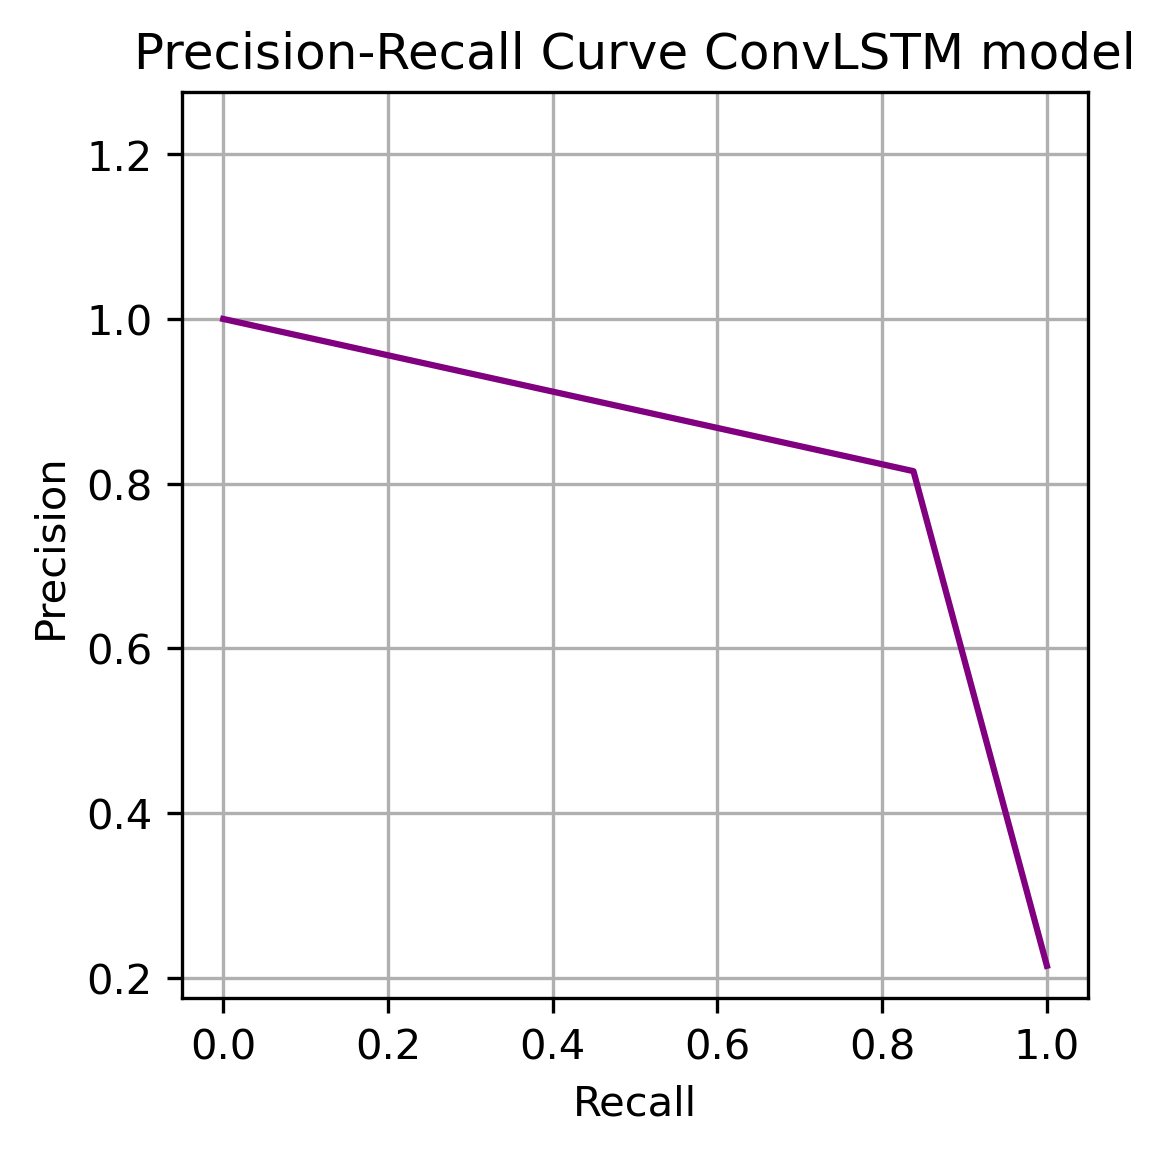

In [76]:
from sklearn.metrics import precision_recall_curve

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve ConvLSTM model')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.grid()
plt.axis('square')
#display plot
plt.show()
